In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
#load the data from csv
# https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
all_data = [df_train, df_test]
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
for df in all_data:
    # some obvious columns that won't be a factor in our model
    df.drop(['Name', 'Ticket'], axis=1, inplace=True) 

df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


In [4]:
for df in all_data:
    # convert Sex into numeric
    # female=0, male=1
    df['Sex'] = pd.Categorical(df['Sex'])
    df['sex_code'] = df['Sex'].cat.codes

df_train['sex_code'].value_counts()

1    577
0    314
Name: sex_code, dtype: int64

In [5]:
for df in all_data:

    # Emarked is missing 2 values.  Just fill them in with most common value: S
    df['Embarked'].fillna('S', inplace=True)

    # convert Embarked to numeric
    # C=0, Q=1, S=2
    df['Embarked'] = pd.Categorical(df['Embarked'])
    df['embarked_code'] = df['Embarked'].cat.codes

df_train['embarked_code'].value_counts()

2    646
0    168
1     77
Name: embarked_code, dtype: int64

In [6]:
for df in all_data:

    # Fix missing Fares by setting them to 0
    df['Fare'].fillna(0, inplace=True)

df_train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [7]:
for df in all_data:
    # new features: relatives
    df['relatives'] = df['SibSp'] + df['Parch']

df_train['relatives'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: relatives, dtype: int64

In [8]:
for df in all_data:
    # new feature: alone
    df.loc[ df['relatives'] > 0, 'alone' ] = 0
    df.loc[ df['relatives'] == 0, 'alone' ] = 1
    df['alone'] = df['alone'].astype(int)

df_train['alone'].value_counts()

1    537
0    354
Name: alone, dtype: int64

In [9]:
for df in all_data:
    # new feature: deck
    df['deck'] = df.Cabin.apply(lambda x: "?" if x is np.nan else x[0])
    # convert deck to a numeric value so we can plot
    df['deck'] = pd.Categorical(df['deck'])
    df['deck_code'] = df['deck'].cat.codes

df_train['deck_code'].value_counts()

0    687
3     59
2     47
4     33
5     32
1     15
6     13
7      4
8      1
Name: deck_code, dtype: int64

In [10]:
# new feature: fare_per_person
for df in all_data:
    df['fare_per_person'] = df['Fare'] / (df['relatives']+1)

df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,sex_code,embarked_code,relatives,alone,deck,deck_code,fare_per_person
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,1,2,1,0,?,0,3.62500
1,2,1,1,female,38.0,1,0,71.2833,C85,C,0,0,1,0,C,3,35.64165
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,0,2,0,1,?,0,7.92500
3,4,1,1,female,35.0,1,0,53.1000,C123,S,0,2,1,0,C,3,26.55000
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,1,2,0,1,?,0,8.05000


In [11]:
mean = df_train["Age"].mean()
std = df_test["Age"].std()

for df in all_data:
    is_null = df["Age"].isnull().sum()

    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)

    
    # fill NaN values in Age column with random values generated
    age_slice = df["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    df["Age"] = age_slice


df_train['Age'].isnull().sum()


0

In [12]:
# drop columns that are not needed for training our model
#df.drop(['Cabin', 'deck'], axis=1, inplace=True)
#df.drop(['Embarked', 'Sex'], axis=1, inplace=True) 

df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Sex                891 non-null category
Age                891 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           891 non-null category
sex_code           891 non-null int8
embarked_code      891 non-null int8
relatives          891 non-null int64
alone              891 non-null int64
deck               891 non-null category
deck_code          891 non-null int8
fare_per_person    891 non-null float64
dtypes: category(3), float64(3), int64(7), int8(3), object(1)
memory usage: 82.5+ KB


In [13]:
df_train.shape

(891, 17)

In [14]:
#MODEL: random forest
from sklearn.ensemble import RandomForestClassifier

y = df_train['Survived']

feature_sets = {
    "v0": ['Pclass', 'Sex', 'SibSp', 'Parch'],
    "v1": ['Pclass', 'Sex', 'Age', 'Embarked', 'SibSp', 'Parch'],
    "v2": ['Pclass', 'sex_code', 'embarked_code', 'relatives', 'alone', 'deck_code', 'Fare' ],
    "v3": ['Pclass', 'sex_code', 'embarked_code', 'relatives', 'alone', 'deck_code', 'fare_per_person' ],
    "v4": ['Pclass', 'Age', 'sex_code', 'embarked_code', 'relatives', 'alone', 'deck_code', 'fare_per_person' ],
    "v5": ['Pclass', 'Age', 'sex_code', 'embarked_code', 'relatives', 'alone', 'deck_code', 'Fare' ],
    "v6": ['Pclass', 'sex_code', 'embarked_code', 'deck_code', 'fare_per_person' ],
    "v7": ['Age', 'sex_code', 'fare_per_person' ]
}

models = { }
model_scores = { }

for version, features in feature_sets.items():

    X = pd.get_dummies(df_train[features])
    
    #model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X, y)

    model.score(X, y)
    s = round(model.score(X, y) * 100, 2)

    models[version] = model
    model_scores[version] = s
    
    print(f"{version} \t=> {s}%")

#print(model_scores)

v0 	=> 81.71%
v1 	=> 93.49%
v2 	=> 92.82%
v3 	=> 92.82%
v4 	=> 98.77%
v5 	=> 98.77%
v6 	=> 92.14%
v7 	=> 97.98%


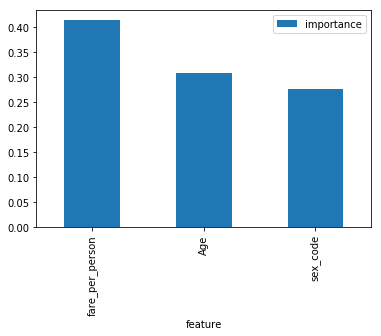

In [15]:
model_version = 'v7'

model = models[model_version]
features = feature_sets[model_version]

X_test = pd.get_dummies(df_test[features])
predictions = model.predict(X_test)
output_df = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': predictions})

importances = pd.DataFrame({'feature':features,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
#importances.head(15)
importances.plot.bar();

In [16]:
output_df.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
